In [1]:
%matplotlib inline

In [2]:
!nvidia-smi

Thu May 15 18:37:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Pytorch Transfer Learning

We've built a few models by hand so far.

But their performance has been poor.

You might be thinking, is there a well-performing model that already exists for our problem?

And in the world of deep learning, the answer is often yes.

We'll see how by using a powerful technique called transfer learning.

In this notebook, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.


## What is transfer learning?

**Transfer learning** allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as [ImageNet](https://www.image-net.org/) (millions of images of different objects) and use them to train new model on CIFAR10.

Or we could take the patterns from a [language model](https://developers.google.com/machine-learning/glossary#masked-language-model) (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

The premise remains: find a well-performing existing model and apply it to your own problem.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-example-overview.png" alt="transfer learning overview on different problems" width=900/>

*Example of transfer learning being applied to computer vision and natural language processing (NLP). In the case of computer vision, a computer vision model might learn patterns on millions of images in ImageNet and then use those patterns to infer on another problem. And for NLP, a language model may learn the structure of language by reading all of Wikipedia (and perhaps more) and then apply that knowledge to a different problem.*


## Where to find pretrained models

The world of deep learning is an amazing place.

So amazing that many people around the world share their work.

Often, code and pretrained models for the latest state-of-the-art research is released within a few days of publishing.

And there are several places you can find pretrained models to use for your own problems.

| **Location** | **What's there?** | **Link(s)** |
| ----- | ----- | ----- |
| **PyTorch domain libraries** | Each of the PyTorch domain libraries (`torchvision`, `torchtext`) come with pretrained models of some form. The models there work right within PyTorch. | [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [`torchtext.models`](https://pytorch.org/text/main/models.html), [`torchaudio.models`](https://pytorch.org/audio/stable/models.html), [`torchrec.models`](https://pytorch.org/torchrec/torchrec.models.html) |
| **HuggingFace Hub** | A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too. | https://huggingface.co/models, https://huggingface.co/datasets |
| **`timm` (PyTorch Image Models) library** | Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features. | https://github.com/rwightman/pytorch-image-models|
| **Paperswithcode** | A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks. | https://paperswithcode.com/ |

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-where-to-find-pretrained-models.png" alt="different locations to find pretrained neural network models" width=900/>

*With access to such high-quality resources as above, it should be common practice at the start of every deep learning problem you take on to ask, "Does a pretrained model exist for my problem?"*

> **Exercise:** Spend 5-minutes going through [`torchvision.models`](https://pytorch.org/vision/stable/models.html) as well as the [HuggingFace Hub Models page](https://huggingface.co/models), what do you find? (there's no right answers here, it's just to practice exploring)


These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

[INFO] Couldn't find torchinfo... installing it.


## 1. Load Data
---------

Before we can start to use **transfer learning**, we'll need a dataset.

To see how transfer learning compares to our previous attempts at model building, we'll use the same CIFAR10 for experimentation.


In [4]:
class CIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, root='./data', train=True, transform=None, download=True):
        self.data = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]  # Returns (image, label) tuple

def get_dataloader(batch_size=32, num_workers=2, root='./data'):
    transform = transforms.Compose([
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    train_dataset = CIFAR10Dataset(root=root, train=True, transform=transform)
    test_dataset = CIFAR10Dataset(root=root, train=False, transform=transform)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_dataloader, test_dataloader

# Get dataloaders
train_dataloader, test_dataloader = get_dataloader(batch_size=32, num_workers=2)

# Define class names
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 16

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 2. Define the training loop



In [5]:
import time
from tqdm.auto import tqdm

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param train_dataloader: DataLoader for training data
        :param test_dataloader: DataLoader for test/validation data
        :param epochs: Number of epochs (default=25)
        :param device: Device to perform computations ('cuda' or 'cpu')

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    # accuracy = torchmetrics.Accuracy(device=device)
    # Initialize the accuracy metric from torchmetrics
    # accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10).to(device)

    for epoch in tqdm(range(epochs)):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_dataloader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

        # Validation - No gradient tracking needed
        with torch.no_grad():

            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)


        # Find average training loss and training accuracy
        avg_train_loss = train_loss / len(train_dataloader.dataset)
        avg_train_acc = train_acc / len(train_dataloader.dataset)

        # Find average validation loss and training accuracy
        avg_test_loss = valid_loss / len(test_dataloader.dataset)
        avg_test_acc = valid_acc / len(test_dataloader.dataset)

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc * 100, avg_test_loss, avg_test_acc * 100, epoch_end - epoch_start))

        # Save if the model has best accuracy till now
        if avg_test_acc > best_acc:
            best_acc = avg_test_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

    return best_model, history

## 3. Finetuning the convnet
----------------------

Load a pretrained model and define a **NEW** final fully connected layer.

Since we're working on a computer vision problem, we can find pretrained classification models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification).

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... |
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` |
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... |
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... |
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` |

### 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. `resnet18()` -> `resnet50()` -> `resnet152()`) means *better performance* but a *larger* model.

You might think better performance is *always better*, right?

That's true but **some better performing models are too big for some devices**.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, you'd likely take the biggest, most compute hungry model you can.

Understanding this **performance vs. speed vs. size tradeoff** will come with time and practice.

For example, a nice balance can be found in the `efficientnet_bX` models.

As of May 2022, [Nutrify](https://nutrify.app) (the machine learning powered app I'm working on) is powered by an `efficientnet_b0`.

[Comma.ai](https://comma.ai/) (a company that makes open source self-driving car software) [uses an `efficientnet_b2`](https://geohot.github.io/blog/jekyll/update/2021/10/29/an-architecture-for-life.html) to learn a representation of the road.

### 3.2 Setting up a pretrained model

The pretrained model we're going to be using is [`torchvision.models.resnet18()`](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18).

The architecture is from the paper *[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)*.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-effnet-b0-feature-extractor.png" alt="efficienet_b0 from PyTorch torchvision feature extraction model" width=900/>

*Example of what we're going to create, a pretrained resnet18 from `torchvision.models` with the output layer adjusted for our use case of classifying objects in CIFAR10.

Let say we are using the Resnet 18 as our pretrained model. We can download and visualize the layers:

In [6]:
model_ft = models.resnet18(pretrained=True)
model_ft

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
summary(model=model_ft,
        input_size=(1, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   True
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   True
│    └─BasicBlock (0)                    [1, 64, 56, 56]      [1, 64, 56, 56]      --                   True
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      36,864               True
│    │    └─BatchN

Our main objective is to **REPLACE** the final classification layer (containing 1000 classes of Imagenet) with a **NEW** classification layer (containing 10, corresponding to 10 classes in CIFAR10)

Therefore, we are accessing the in_features of the fc (fully connected) layer and connect it to a newly defined layer containing 10 neurons:

In [8]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(train_data.classes)).
model_ft.fc = nn.Linear(num_ftrs, 10)

# LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_ft = model_ft.to(device)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [9]:
num_epochs = 5
trained_model, history = train_and_validate(model_ft, loss_fn, optimizer, train_dataloader, test_dataloader, num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
Epoch : 000, Training: Loss: 0.9848, Accuracy: 65.0440%, 
		Validation : Loss : 0.9466, Accuracy: 68.0500%, Time: 170.8920s
Epoch: 2/5
Epoch : 001, Training: Loss: 0.6474, Accuracy: 77.5100%, 
		Validation : Loss : 0.6925, Accuracy: 75.3200%, Time: 171.3906s
Epoch: 3/5
Epoch : 002, Training: Loss: 0.5270, Accuracy: 81.6920%, 
		Validation : Loss : 0.6754, Accuracy: 76.9300%, Time: 172.0531s
Epoch: 4/5
Epoch : 003, Training: Loss: 0.4400, Accuracy: 84.6200%, 
		Validation : Loss : 0.7571, Accuracy: 73.7300%, Time: 171.9580s
Epoch: 5/5
Epoch : 004, Training: Loss: 0.3651, Accuracy: 87.1860%, 
		Validation : Loss : 0.7094, Accuracy: 76.5700%, Time: 171.9069s


In [10]:
#Analyze the loss curve

def plot_loss(history):
  history = np.array(history)
  plt.plot(history[:,0:2])
  plt.legend(['Tr Loss', 'Val Loss'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Loss')
  plt.ylim(0,3)
  # plt.savefig('cifar10_loss_curve.png')
  plt.show()

def plot_accuracy(history):
  history = np.array(history)
  plt.plot(history[:,2:4])
  plt.legend(['Tr Accuracy', 'Val Accuracy'])
  plt.xlabel('Epoch Number')
  plt.ylabel('Accuracy')
  plt.ylim(0,1)
  # plt.savefig('cifar10_accuracy_curve.png')
  plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def plot_confusionMatrix(model, test_dataloader):

  y_pred = []
  y_true = []

  model.to('cpu')

  # iterate over test data
  for inputs, labels in test_dataloader:
          output = model(inputs) # Feed Network

          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction

          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_names],
                      columns = [i for i in class_names])
  plt.figure(figsize = (20,10))
  sn.heatmap(df_cm, annot=True)
  # plt.savefig('output.png')

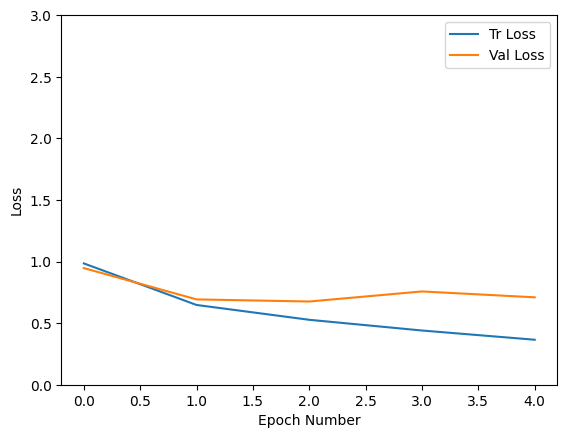

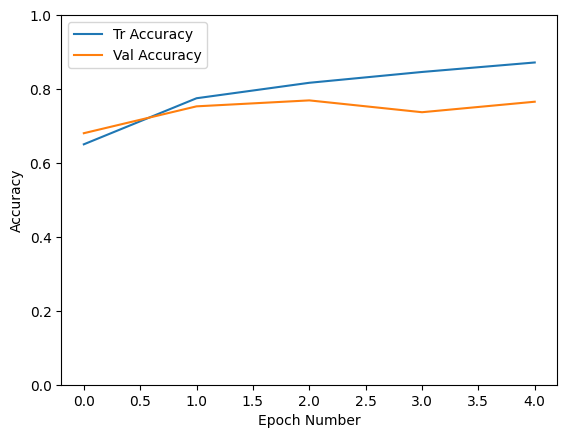

In [11]:
plot_loss(history)
plot_accuracy(history)

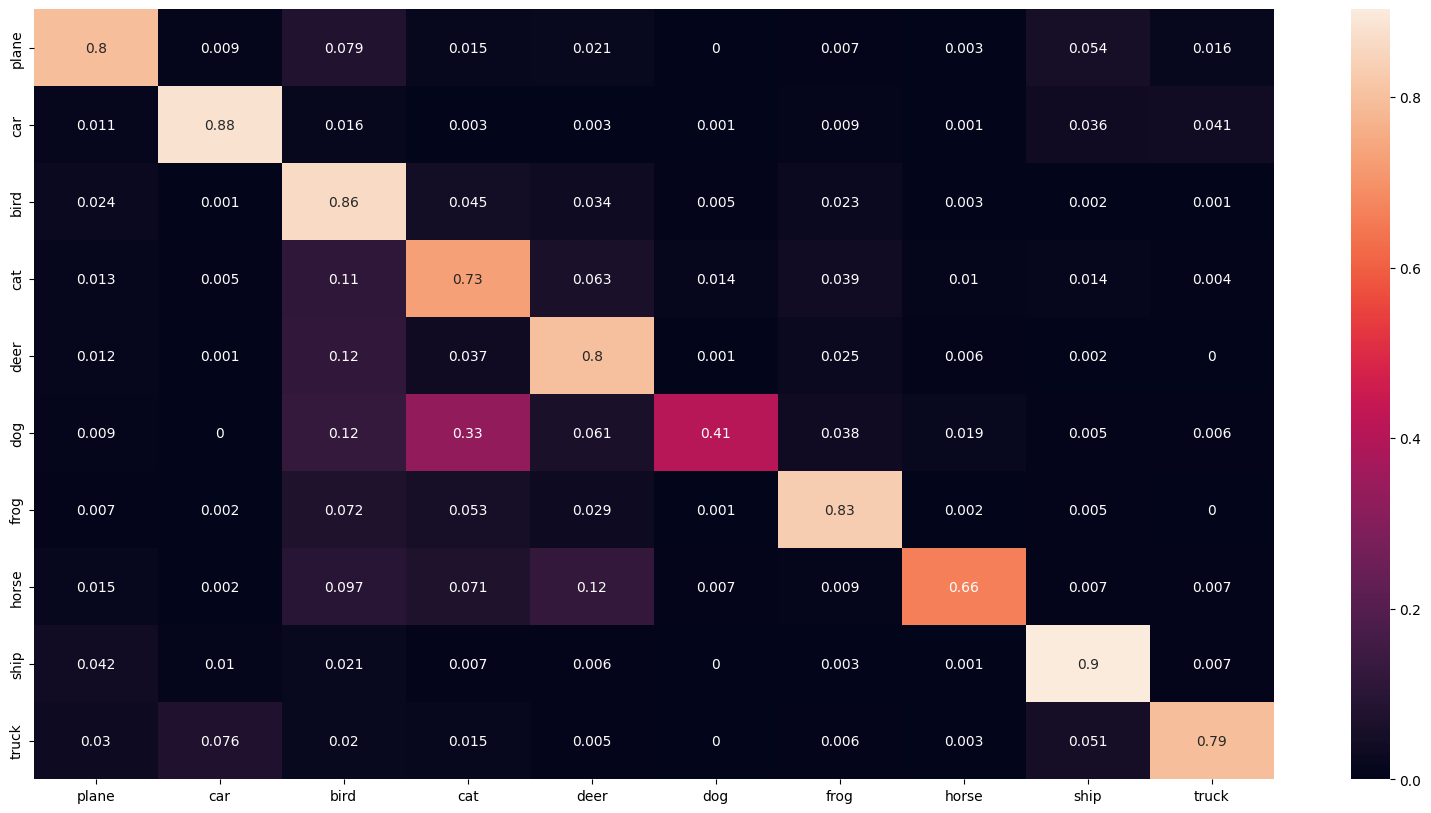

In [12]:
plot_confusionMatrix(trained_model, test_dataloader)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# move the model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_conv = model_conv.to(device)

In [ ]:
summary(model=model_conv,
        input_size=(4, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [4, 3, 224, 224]     [4, 10]              --                   Partial
├─Conv2d (conv1)                         [4, 3, 224, 224]     [4, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [4, 64, 112, 112]    [4, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [4, 64, 112, 112]    [4, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [4, 64, 112, 112]    [4, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [4, 64, 56, 56]      [4, 64, 56, 56]      --                   False
│    └─BasicBlock (0)                    [4, 64, 56, 56]      [4, 64, 56, 56]      --                   False
│    │    └─Conv2d (conv1)               [4, 64, 56, 56]      [4, 64, 56, 56]      (36,864)             False
│    │    

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
num_epochs = 5
trained_model, history = train_and_validate(model_conv, loss_fn, optimizer, train_dataloader, test_dataloader, num_epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
Epoch : 000, Training: Loss: 1.7606, Accuracy: 37.2700%, 
		Validation : Loss : 1.6446, Accuracy: 41.5800%, Time: 94.9336s
Epoch: 2/5
Epoch : 001, Training: Loss: 1.6112, Accuracy: 43.0680%, 
		Validation : Loss : 1.5910, Accuracy: 44.2200%, Time: 96.0206s
Epoch: 3/5
Epoch : 002, Training: Loss: 1.5761, Accuracy: 44.1500%, 
		Validation : Loss : 1.5518, Accuracy: 45.3900%, Time: 95.6692s
Epoch: 4/5


In [ ]:
plot_loss(history)
plot_accuracy(history)

In [ ]:
plot_confusionMatrix(trained_model, test_dataloader)

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





#Data Augmentation

In [ ]:
def get_dataloader(batch_size=4, num_workers=0, root='./data'):
    transform = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    train_dataset = CIFAR10Dataset(root=root, train=True, transform=transform)
    test_dataset = CIFAR10Dataset(root=root, train=False, transform=transform)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_dataloader, test_dataloader